In [17]:
!pip3 install vaderSentiment

     |████████████████████████████████| 133kB 3.5MB/s 


In [66]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from nltk.cluster import KMeansClusterer,cosine_distance, euclidean_distance
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

In [1]:
!pip3 install spacy-transformers

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 245kB 8.9MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 10.0MB 25.8MB/s 
     |████████████████████████████████| 573kB 63.9MB/s 
     |████████████████████████████████| 2.1MB 67.2MB/s 
     |████████████████████████████████| 3.7MB 63.0MB/s 
     |████████████████████████████████| 1.1MB 63.0MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 
     |████████████████████████████████| 6.7MB 28.7MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=092b73b8d9fb2efb6424d8e2b56767f25c199002934dd49d8d89327da31826fc
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl s

In [2]:
!python3 -m spacy download en_trf_bertbaseuncased_lg

     |████████████████████████████████| 405.8MB 1.1MB/s 
  Created wheel for en-trf-bertbaseuncased-lg: filename=en_trf_bertbaseuncased_lg-2.3.0-cp36-none-any.whl size=405808565 sha256=8adf0ad8f17f5ee3bf1c7ae13a6a5b470f74e400ad79d867389db8644ac6701d
  Stored in directory: /tmp/pip-ephem-wheel-cache-u77zwu0j/wheels/34/31/e9/a65093916b43098517a3f131d614b0b215b33186ca6577e74d
Successfully built en-trf-bertbaseuncased-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [10]:
import spacy
import pandas as pd

In [7]:
nlp=spacy.load('/usr/local/lib/python3.6/dist-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')

Let's test it to see if it's working well.

In [8]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # 0.73428553
print(apple1[0].similarity(apple3[0]))  # 0.43365782

0.73428565
0.43365785


In [39]:
reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/reviews_and_ratings.csv')

In [40]:
reviews_ratings.head(2)

,overall,reviewText
0,1,I was a huge fan when the Divergent series sta...
1,4,Excellent read.


In [41]:
reviews_ratings.shape

(5535445, 2)

In [88]:
#Let's just take the first 10_000 rows to test for feasibility.
reviews_ratings_selection=reviews_ratings.loc[:1_000_000]

In [89]:
reviews_ratings.dropna(inplace=True)

In [90]:
#parameters for tokenization
max_len=100
training_samples=400_000
validation_samples=100_000
max_words=10_000

In [91]:
#instantiate the tokenizer
tokenizer=Tokenizer(num_words=max_words)

In [92]:
#fit the tokenizer
tokenizer.fit_on_texts(reviews_ratings_selection['reviewText'])

In [93]:
#create the sequences
sequences=tokenizer.texts_to_sequences(reviews_ratings_selection['reviewText'])

In [94]:
#pad sequences
data=pad_sequences(sequences,maxlen=max_len) #to be able to handle docs too small to feed.

In [95]:
#y is rating (here referred to as 'overall')
y=reviews_ratings_selection['overall']

In [96]:
#create train/test sets
X_train=data[:training_samples]
X_test=data[training_samples:training_samples+validation_samples]

y_train=y[:training_samples]
y_test=y[training_samples:training_samples+validation_samples]

In [97]:
#simple network model
model=Sequential()
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

In [105]:
#test architecture
model=Sequential([
    layers.Input(shape=(100, )),
    layers.BatchNormalization(),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(125,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(50,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(25,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(1,activation='linear')
])

In [106]:
#compile
model.compile(optimizer='adam',loss='mae',metrics='mse')

In [107]:
#fit
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,verbose=1)

Epoch 1/50
12500/12500 [==============================] - 33s 3ms/step - loss: 0.6948 - mse: 1.3677 - val_loss: 0.6048 - val_mse: 1.2867
Epoch 2/50
12500/12500 [==============================] - 34s 3ms/step - loss: 0.6230 - mse: 1.4480 - val_loss: 0.5754 - val_mse: 1.3572
Epoch 3/50
12500/12500 [==============================] - 51s 4ms/step - loss: 0.6184 - mse: 1.4872 - val_loss: 0.5762 - val_mse: 1.3539
Epoch 4/50
12500/12500 [==============================] - 33s 3ms/step - loss: 0.6182 - mse: 1.4903 - val_loss: 0.5807 - val_mse: 1.3399
Epoch 5/50
12500/12500 [==============================] - 33s 3ms/step - loss: 0.6183 - mse: 1.4903 - val_loss: 0.5805 - val_mse: 1.3673
Epoch 6/50
12500/12500 [==============================] - 33s 3ms/step - loss: 0.6181 - mse: 1.4906 - val_loss: 0.5818 - val_mse: 1.3687
Epoch 7/50
12500/12500 [==============================] - 33s 3ms/step - loss: 0.6180 - mse: 1.4910 - val_loss: 0.5803 - val_mse: 1.3671
Epoch 8/50
12500/12500 [=================

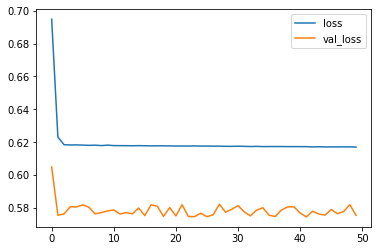

In [108]:
#examine the loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend();

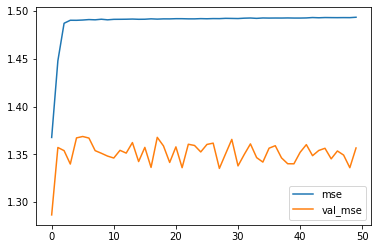

In [109]:
plt.plot(history.history['mse'],label='mse')
plt.plot(history.history['val_mse'],label='val_mse')
plt.legend()

In [111]:
preds=model.predict(X_test)

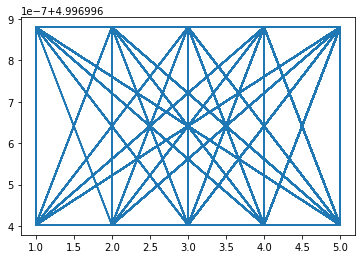

In [112]:
plt.plot(y_test,preds)

In [114]:
pd.DataFrame(preds).describe()

,0
count,100000.000000
mean,4.999519
std,0.002522
min,4.996996
25%,4.996997
50%,4.996997
75%,4.996997
max,4.996997


In [115]:
pd.DataFrame(y_test).describe()

,overall
count,100000.000000
mean,4.425670
std,1.015049
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000
